In [1]:
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import numpy as np
from scipy.special import erf
import h5py
import os
from unyt import angstrom, Msun, yr, m, erg, s, Hz

from synthesizer.grid import Grid
from synthesizer import Sed

import swiftascmaps
import cmasher as cmr


plt.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 14})

def get_n_colors_from_cmap(n, cmap_name="viridis"):
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i) for i in np.linspace(0, 0.9, n)]
    return colors

In [26]:
pipeline_dir = '/mnt/home/snewman/ceph/pipeline_results'
pipeline_base = 'pipeline_agn_allz_{subvol}_{rank}.hdf5'
wavelengths = np.logspace(0.1, 6, 10000) * angstrom

def load_pipeline_data(subvol, ranks):
    """
    Load and combine galaxy spectra and redshift data from all rank files.

    Parameters
    ----------
    subvol : str
        Subvolume identifier (e.g. "0_0_0").
    ranks : list[int]
        List of ranks whose HDF5 files to combine.

    Returns
    -------
    total_spectra, star_spectra, bh_spectra, redshift : ndarray
        Combined arrays for all galaxies across ranks.
    """
    total_spectra_list = []
    star_spectra_list = []
    bh_spectra_list = []
    redshift_list = []

    grp_total = 'Galaxies/Spectra/SpectralLuminosityDensities/total'
    grp_star = 'Galaxies/BlackHoles/Spectra/SpectralLuminosityDensities/agn_incident'
    grp_bh = 'Galaxies/Stars/Spectra/SpectralLuminosityDensities/stellar_incident'

    for rank in ranks:
        fname = os.path.join(pipeline_dir, pipeline_base.format(subvol=subvol, rank=rank))
        if not os.path.exists(fname):
            print(f"⚠️ File not found: {fname}")
            continue

        with h5py.File(fname, 'r') as f:
            total_spectra_list.append(f[grp_total][:])
            star_spectra_list.append(f[grp_star][:])
            bh_spectra_list.append(f[grp_bh][:])
            redshift_list.append(f['Galaxies/Redshift'][:])

    if not total_spectra_list:
        raise FileNotFoundError("No valid rank files found for this subvolume.")

    total_spectra = np.concatenate(total_spectra_list)
    star_spectra = np.concatenate(star_spectra_list)
    bh_spectra = np.concatenate(bh_spectra_list)
    redshift = np.concatenate(redshift_list)

    print(f"✅ Loaded {total_spectra.shape[0]} galaxies across {len(ranks)} ranks for subvol {subvol}.")

    return total_spectra, star_spectra, bh_spectra, redshift


def calculate_luminosity_function(total_spectra, wavelength1, wavelength2):
    """
    Calculate the luminosity function from combined spectra.

    Parameters
    ----------
    total_spectra : ndarray
        Combined total spectra from all ranks.
    wavelength1, wavelength2 : float
        Wavelength window (in Angstroms).

    Returns
    -------
    bin_centers : ndarray
        Centers of luminosity bins (in log10(L)).
    phi : ndarray
        Luminosity function values.
    sigma_phi : ndarray
        Poisson errors on the LF.
    """
    # Compute luminosities
    sed = Sed(wavelengths, total_spectra * erg / (s * Hz))
    band_window_limits = (wavelength1 * angstrom, wavelength2 * angstrom)
    band_lum = sed.measure_window_luminosity(band_window_limits)
    log_band_lum = np.log10(band_lum)

    print(f"💡 Calculated luminosities for {len(log_band_lum)} galaxies between {wavelength1}-{wavelength2} Å.")

    # Define the simulation volume (CAMELS-SAM)
    BOX_SIZE = 150.0  # Mpc
    VOLUME = BOX_SIZE**3  / 8 

    # Compute luminosity function
    DEX_WIDTH = 0.5
    bins = np.arange(np.floor(log_band_lum.min()), np.ceil(log_band_lum.max()) + DEX_WIDTH, DEX_WIDTH)
    hist, edges = np.histogram(log_band_lum, bins=bins)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    phi = hist / (VOLUME * DEX_WIDTH)
    sigma_phi = np.sqrt(hist) / (VOLUME * DEX_WIDTH)

    print(f"📊 Calculated luminosity function between {wavelength1}-{wavelength2} Å.")

    return bin_centers, phi, sigma_phi


In [24]:
def plot_lf(bin_centers, phi, sigma_phi, plot_label, line_color):

    # For plotting, avoid zeros when using log
    positive = phi > 0

    # Plot the LF
    plt.plot(bin_centers[positive], phi[positive], color=line_color, lw=3, label=plot_label)

    # Add poisson error shading
    plt.fill_between(bin_centers[positive],
                    phi[positive] - sigma_phi[positive],
                    phi[positive] + sigma_phi[positive],
                    color="gray", alpha=0.3)

In [4]:
subvol = "0_0_0"
ranks = range(0, 4) # or whatever ranks exist

total_spectra, star_spectra, bh_spectra, redshift = load_pipeline_data(subvol, ranks)

✅ Loaded 165084 galaxies across 4 ranks for subvol 0_0_0.


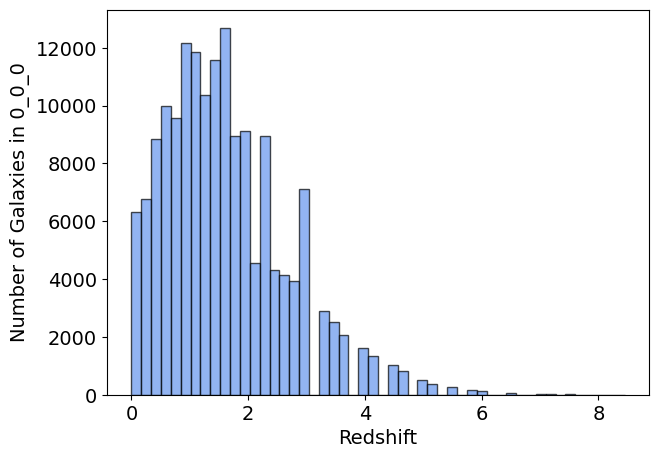

In [21]:
plt.figure(figsize=(7, 5))
plt.hist(redshift, bins=50, color='cornflowerblue', alpha=0.7, edgecolor='black')
plt.xlabel('Redshift')
plt.ylabel('Number of Galaxies in 0_0_0')
plt.show()

# Then sample total_spectra for different redshift bins 

def sample_spectra_by_redshift(spectra, redshifts, z_min, z_max):

    mask = (redshift >= z_min) & (redshift < z_max)
    selected_spectra = total_spectra[mask]
    selected_redshifts = redshifts[mask]
    print(f"Selected {selected_spectra.shape[0]} galaxies with {z_min:.2f} ≤ z < {z_max:.2f}.")

    return selected_spectra

Selected 3786 galaxies with 0.00 ≤ z < 0.10.
💡 Calculated luminosities for 3786 galaxies between 1500-1700 Å.
📊 Calculated luminosity function between 1500-1700 Å.
Selected 18151 galaxies with 0.10 ≤ z < 0.50.
💡 Calculated luminosities for 18151 galaxies between 1500-1700 Å.
📊 Calculated luminosity function between 1500-1700 Å.
Selected 31687 galaxies with 0.50 ≤ z < 1.00.
💡 Calculated luminosities for 31687 galaxies between 1500-1700 Å.
📊 Calculated luminosity function between 1500-1700 Å.
Selected 64544 galaxies with 1.00 ≤ z < 2.00.
💡 Calculated luminosities for 64544 galaxies between 1500-1700 Å.
📊 Calculated luminosity function between 1500-1700 Å.
Selected 33015 galaxies with 2.00 ≤ z < 3.00.
💡 Calculated luminosities for 33015 galaxies between 1500-1700 Å.
📊 Calculated luminosity function between 1500-1700 Å.
Selected 9108 galaxies with 3.00 ≤ z < 4.00.
💡 Calculated luminosities for 9108 galaxies between 1500-1700 Å.
📊 Calculated luminosity function between 1500-1700 Å.
Selected

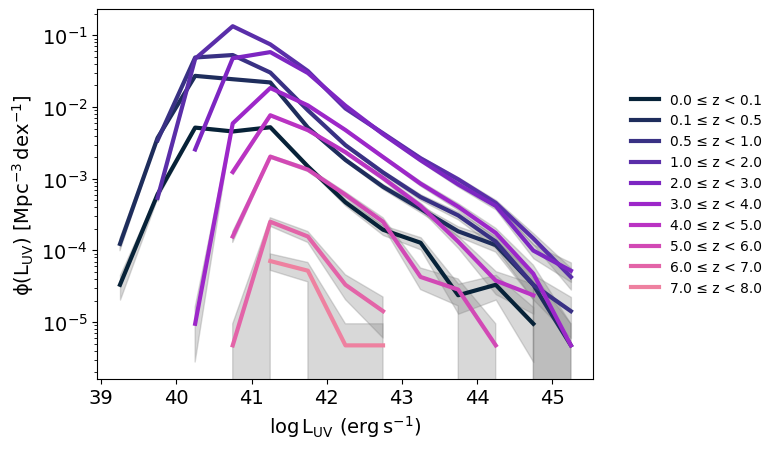

In [27]:
redshift_bins = [0, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8]
wavelength1, wavelength2 = 1500, 1700  

colors = get_n_colors_from_cmap(len(redshift_bins), cmr.bubblegum)

# for each redshift bin
for i in range(len(redshift_bins) - 1):
    z_min, z_max = redshift_bins[i], redshift_bins[i + 1]
    spectra_bin = sample_spectra_by_redshift(total_spectra, redshift, z_min, z_max)

    # get luminosity function
    bin_centers, phi, sigma_phi = calculate_luminosity_function(spectra_bin, wavelength1, wavelength2)

    # and plot  
    plot_label = f"{z_min:.1f} ≤ z < {z_max:.1f}"
    plot_lf(bin_centers, phi, sigma_phi, plot_label=plot_label, line_color=colors[i])

plt.yscale('log')
plt.xlabel(r'$\rm \log L_{UV}\ (\mathrm{erg\,s^{-1}})$')
plt.ylabel(r'$\rm \phi(L_{UV})\ [\mathrm{Mpc^{-3}\,dex^{-1}}]$')
plt.legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),  # moves it just outside the right edge
    fontsize=10,
    frameon=False
)

(165084, 10000)


/tmp/ipykernel_2727267/810285900.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(lams), np.log10(lnu_total), lw=2, label='total')
/tmp/ipykernel_2727267/810285900.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(lams), np.log10(lnu_star), lw=2, label='star')
/tmp/ipykernel_2727267/810285900.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(lams), np.log10(lnu_bh), lw=2, label='bh')


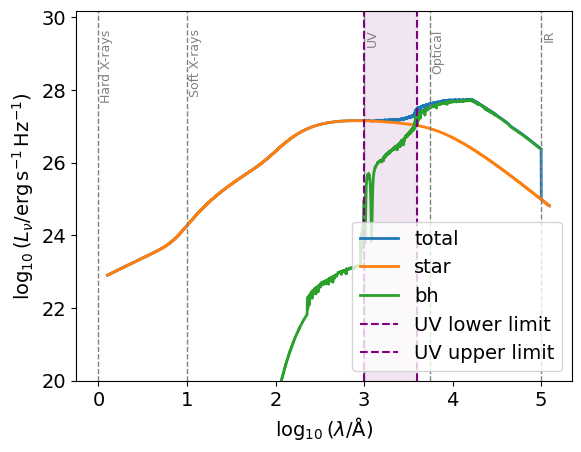

In [16]:
print(total_spectra.shape)

lnu_total = total_spectra[0, :]
lnu_star = star_spectra[0, :]
lnu_bh = bh_spectra[0, :]
lams = np.logspace(0.1, 6, 10000) 

plt.plot(np.log10(lams), np.log10(lnu_total), lw=2, label='total')
plt.plot(np.log10(lams), np.log10(lnu_star), lw=2, label='star')
plt.plot(np.log10(lams), np.log10(lnu_bh), lw=2, label='bh')

# Add reference wavelength bands
bands = {
    'Hard X-rays': 1,        # ~1 Å
    'Soft X-rays': 10,       # ~10 Å
    'UV': 1000,              # ~1000 Å
    'Optical': 5500,         # ~5500 Å
    'IR': 100000,            # ~1e5 Å (10 µm)
}

for label, lam in bands.items():
    plt.axvline(np.log10(lam), color='gray', ls='--', lw=1)
    plt.text(np.log10(lam) + 0.02, plt.ylim()[1] - 0.5, label,
             rotation=90, va='top', ha='left', fontsize=9, color='gray')

# --- Add UV wavelength range limits (approx. 1000–4000 Å) ---
uv_lower = 1000   # lower limit (far UV)
uv_upper = 4000   # upper limit (near UV)

plt.axvline(np.log10(uv_lower), color='purple', ls='--', lw=1.5, label='UV lower limit')
plt.axvline(np.log10(uv_upper), color='purple', ls='--', lw=1.5, label='UV upper limit')

# Optional: shaded region to highlight the UV range
plt.axvspan(np.log10(uv_lower), np.log10(uv_upper), color='purple', alpha=0.1)


plt.xlabel(r"$\log_{10}(\lambda/\rm{\AA})$")
plt.ylabel(r"$\log_{10}(L_\nu/\rm{erg\,s^{-1}\,Hz^{-1}})$")
plt.ylim(bottom=20)
plt.legend()